In [3]:
#!/usr/bin/python


import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import matplotlib.pyplot as plt

In [4]:
min_num_inliers = 10 # minimum inliers for selecting a match


'''
@pre_processing performs required operations like resizing or blurring etc.on passed image 
and returns processed image.
Second argument is for type of image whether index or recog (query) image.
'''

def pre_processing(img, img_type, max_size_for_index_image=300, min_size_for_index_image=300, min_size_for_recog_image=300, convert_gray_scale=True):
    img_w = img.shape[1]
    img_h = img.shape[0]

    if img_type == "index":

        '''scaling image down to max_size_for_index_image maintaining aspect ratio if it's bigger
           than max_size_for_index_image
        '''
        if img_w > max_size_for_index_image  and img_h > max_size_for_index_image:
            r =  float(max_size_for_index_image)/ img_w
            dim = (max_size_for_index_image, int(img_h * r))
            # perform the actual resizing of the image
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        elif img_w < min_size_for_index_image  and img_h < min_size_for_index_image:
            r =  float(min_size_for_index_image)/ img_w
            dim = (min_size_for_index_image, int(img_h * r))
            # perform the actual resizing of the image
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    # recog image
    else:
        '''scaling image up to min_size_for_recog_image maintaining aspect ratio if it's smaller
           than min_size_for_recog_image
        '''
        if img_w < min_size_for_recog_image  and img_h < min_size_for_recog_image:
            r = float(min_size_for_recog_image) / img_w
            dim = (min_size_for_recog_image, int(img_h * r))
            # perform the actual resizing of the image
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
#    print "shape",img.shape

    #check if image is grayscale. If not then converting it to grayscale.

    if convert_gray_scale:
	    if not (len(img.shape)<3):
    		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

'''
@compute_features will generate key points with descriptors given an image.
'''
def compute_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints and desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc


'''
@feature_matching will generate feature matching pairs given two sets of features
which are representing index and recog images.
'''
def feature_matching(desc1,desc2):
    # create a BFMatcher(bruteforceMatcher) object which will match up the SIFT features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2) # two nearest neighbours

    #################################################
    # If speed issue comes then FLANN DB can be used#
    #################################################

    # FLANN_INDEX_KDTREE = 0
    # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # search_params = dict(checks = 50)
    # flann = cv2.FlannBasedMatcher(index_params, search_params)

    # matches = flann.knnMatch(octo_front_desc,octo_offset_desc,k=2)

    return matches

'''
@ratio_test_filter applies D.lowe ratio test on the proposed matches.
In ratio test, Let d1 be the distance to the nearest neighbor and 
d2 be the distance to the next one. In order to accept the nearest neighbor
as a match, d1/d2 ratio should be smaller than a given threshold (something like 0.8)
'''
def ratio_test_filter(matches):
    # Apply ratio test
    good_m = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_m.append(m)
    # return only the good matches
    return good_m


def homography_check(M):
    ## Homography check

    # +ve means same orientation -ve means image flipped
    det = np.linalg.det(M[0:2, 0:2])
    if (det < 0):
        return False

    # higher value shows too much rotation or skewness in one direction
    x_scale = np.sqrt(M[0][0] * M[0][0] + M[1][0] * M[1][0])  # 0.1 to 4

    if x_scale < 0.85 or x_scale > 1.15:
        return False

    y_scale = np.sqrt(M[0][1] * M[0][1] + M[1][1] * M[1][1])

    if y_scale < 0.85 or y_scale > 1.15:
        return False

    #Check out of plane rotation
    perspectivity = np.sqrt(M[2][0] * M[2][0] + M[2][1] * M[2][1])  # < 0.005

    if perspectivity > 0.05:
        return False
    #print det, x_scale, y_scale, perspectivity
    return True



'''
@perform_transformations performs Hough transform and ransac to find best fit homography. 
This will identify clusters of features that vote for the same object pose 
and filter outs outliers.
Finally, perspective transformations will be done to find projected index image corners on
recog image.
ROI contains the coordinates of index image projected on recog image. Anti-clockwise staring 
from left top. y
ROI list: [[x_left_top,y_left_top],[x_left_bottom,y_left_bottom],[x_right_bottom,y_right_bottom],
[x_right_top,y_right_top]]
Note: img_recog_shape will be used in normalizing roi so they canbe plotted on even scaled 
recog images. ( will be added soon)
'''

def perform_transformations(good_m, key_pnts_index, key_pnts_recog, img_index_shape=(300,300), img_recog_shape=(300,300),homography_test=True):
    matchesMask = []  # zero for deleted matches and one for selected ones
    roi = []
    # Check if enough matches are found
    # print len(good_m)
    if len(good_m) > 10:
        src_pts = np.float32([key_pnts_index[m.queryIdx] for m in good_m]).reshape(-1, 1, 2)
        dst_pts = np.float32([key_pnts_recog[m.trainIdx] for m in good_m]).reshape(-1, 1, 2)

        # find best fit homography using RANSAC
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

        if M is None :
            return None,None

        matchesMask = mask.ravel().tolist()


        # computing final number of inliers
        indices = [i for i, x in enumerate(matchesMask) if x == 1]

        #suspecion cases
        if len(indices) < 40 and homography_test :
            if not homography_check(M):
                return len(indices), None


        # Projecting index image on recog image
        h, w = img_index_shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        dst = np.int32(dst)
        # extract roi in Anti-clockwise coordinates starting from left top corner.
        left_top = [int(dst[0][0][0]), int(dst[0][0][1])]
        left_bottom = [int(dst[1][0][0]), int(dst[1][0][1])]
        right_bottom = [int(dst[2][0][0]), int(dst[2][0][1])]
        right_top = [int(dst[3][0][0]), int(dst[3][0][1])]

        # Area test
        area_1 = (right_bottom[0] - left_top[0]) * (right_bottom[1] - left_top[1])
        area_2 = (right_top[0] - left_bottom[0]) * (left_bottom[1] - right_top[1])
        if abs(area_1) < 200 or abs(area_2) < 200:
            return len(indices), None

        roi.append(left_top)
        roi.append(left_bottom)
        roi.append(right_bottom)
        roi.append(right_top)


        # Return total num of final inliers and roi
        return len(indices), roi

    else:  # "Not enough matches are found"
        return None, None


'''
@perform_transformations_directly_from_image is same as perform_transformations, only difference is
it's for direct image to image (no stored descriptor for index image) 
'''
def perform_transformations_directly_from_image(good_m,key_pnts_index, key_pnts_recog, img_index_shape, img_recog_shape ):

    matchesMask=[] # zero for deleted matches and one for selected ones
    roi=[]

    # Check if enough matches are found
    if len(good_m) > min_num_inliers :
        src_pts = np.float32([ key_pnts_index[m.queryIdx].pt for m in good_m ]).reshape(-1,1,2)
        dst_pts = np.float32([ key_pnts_recog[m.trainIdx].pt for m in good_m ]).reshape(-1,1,2)

        # find best fit homography using RANSAC
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,3.0)
        matchesMask = mask.ravel().tolist()
        # Projecting index image on recog image
        h,w = img_index_shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        dst  = np.int32(dst)
        # extract roi in Anti-clockwise coordinates starting from left top corner.
        left_top = [int(dst[0][0][0]),int(dst[0][0][1])]
        left_bottom = [int(dst[1][0][0]),int(dst[1][0][1])]
        right_bottom = [int(dst[2][0][0]),int(dst[2][0][1])]
        right_top = [int(dst[3][0][0]),int(dst[3][0][1])]
        roi.append(left_top)
        roi.append(left_bottom)
        roi.append(right_bottom)
        roi.append(right_top)
        #computing final number of inliers
        indices = [i for i, x in enumerate(matchesMask) if x == 1]

        #Return total num of final inliers and roi
        return len(indices),roi

    else:# "Not enough matches are found"
        return None,None

'''
@run is the integration of full pipeline
'''
def run(index_img,recog_img):

    #min_size_for_recog_image = 1000
    #max_size_for_index_image = 100
    #min_size_for_index_image = 100

    index_img = pre_processing(index_img, "index",min_size_for_index_image = 30, max_size_for_index_image=100)
    recog_img = pre_processing(recog_img, "recog",min_size_for_recog_image=1000)
    print(recog_img.shape)

    key_pnts_index, desc_index = compute_features(index_img)
    key_pnts_recog, desc_recog = compute_features(recog_img)

    matching_pairs = feature_matching(desc_index, desc_recog)

    matching_pairs = ratio_test_filter(matching_pairs)

    num_inliers, roi = perform_transformations_directly_from_image(matching_pairs, key_pnts_index, key_pnts_recog, index_img.shape,
                                               recog_img.shape)

    if num_inliers != None:
        print("Total number of good matches found: ", num_inliers)
        print("Index image location in recog image: ", roi)

    else:
        print("Not enough matches are found: ", len(matching_pairs))

    return num_inliers, roi


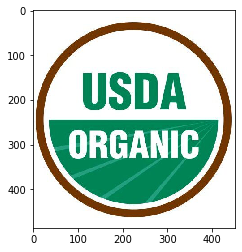

(1500, 1150)
Total number of good matches found:  66
Index image location in recog image:  [[280, 328], [280, 566], [502, 567], [502, 328]]


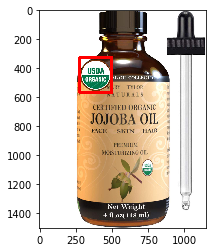

In [18]:
if __name__== "__main__":
    index_img = cv2.imread('usda_logo.jpg')
    recog_img = cv2.imread('61rcCoJXrOL._SL1500_.jpg')
    image = mpimg.imread("usda_logo.jpg")
    plt.imshow(image)
    plt.show()
    inlier,roi=run(index_img,recog_img)
    image2 = mpimg.imread("61rcCoJXrOL._SL1500_.jpg")
    cv2.rectangle(image2,(roi[0][0],roi[0][1]),(roi[2][0],roi[2][1]),(255,0,0),20)
    plt.imshow(image2)
    plt.savefig('example1.png')
    plt.show()


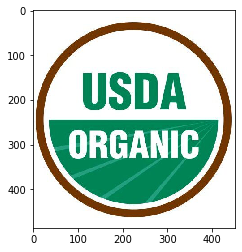

(1500, 1500)
Total number of good matches found:  17
Index image location in recog image:  [[1394, 31], [1398, 135], [1488, 133], [1493, 35]]


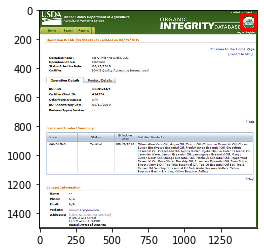

In [19]:
if __name__== "__main__":
    index_img = cv2.imread('usda_logo.jpg')
    recog_img = cv2.imread('719aotpJftL._SL1500_.jpg')
    image = mpimg.imread("usda_logo.jpg")
    plt.imshow(image)
    plt.show()
    inlier,roi=run(index_img,recog_img)
    image2 = mpimg.imread("719aotpJftL._SL1500_.jpg")
    cv2.rectangle(image2,(roi[0][0],roi[0][1]),(roi[2][0],roi[2][1]),(255,0,0),20)
    plt.imshow(image2)
    plt.savefig('example2.png')
    plt.show()